In [6]:
import torch; torch.manual_seed(0)
import torch.distributions
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os, sys, glob
import pandas as pd
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from os.path import dirname, join, abspath
from models.vanilla_vae import VanillaVAE
%load_ext autoreload
%autoreload 2
from utils import TiffDataset


device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 30
batch_size = 4096
lr = 0.001
channels = [0,1,2,3,4,5]
in_channels = len(channels)
latent_dims = 2
hidden_dims = [16, 32, 64, 128, 256]
best_loss_val = 99999999
transform_to_image = T.ToPILImage()
cores_folder = 'TMA_18_810/'
files_path='/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/{0}'.format(cores_folder)
model_path='/data/projects/pixel_project/saved_models'
model_name = "smallmodel_vae.pth.tar"
input_dimensions = (128, 128)
patches_statistics_df = pd.read_csv('../data/patch_size_128_stat_channel0.csv')
patches_statistics_df.sort_values(by=['Median'], ascending=False, inplace=True)
highest_median_pathes = ['/data/projects/pixel_project/datasets/NKI_project_TMAs/patches/randomly_generated/TMA_18_810/{0}/{1}'.format(row['Core'],row['Patch']) for i, row in patches_statistics_df.head(5).iterrows()]
model = VanillaVAE(in_channels=in_channels,latent_dim=latent_dims,input_dimensions=input_dimensions,hidden_dims=hidden_dims).to(device) # GPU
checkpoint = torch.load('{0}/{1}'.format(model_path,model_name))
for key in list(checkpoint['state_dict'].keys()):
    if 'module.' in key:
        checkpoint['state_dict'][key.replace('module.', '')] = checkpoint['state_dict'][key]
        del checkpoint['state_dict'][key]
model.load_state_dict(checkpoint['state_dict'])
model.eval()


# load the patches
patches_files = [os.path.join(r, fn)
        for r, ds, fs in os.walk(files_path)
        for fn in fs if fn.endswith('.tiff')]
patches_files = [file for file in patches_files if file in highest_median_pathes]
tiff_dataset = TiffDataset(files=patches_files,files_names=patches_files,transform=T.Resize(input_dimensions), channels=channels)

data_loader = torch.utils.data.DataLoader(
        tiff_dataset, batch_size=batch_size, shuffle=False,
         pin_memory=True)

# Try to generate Latent space :/
with torch.no_grad():
    for i, (images,filenames) in enumerate(data_loader):
        images = images.cuda()
        filenames = filenames
        x_hat = model(images)
        loss = model.loss_function(*x_hat, M_N=0.00025)
        #z = x_hat[4]
        #value = z.cpu().detach().numpy()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
images_sum = {i: image.cpu().numpy()[0,:,:].sum() for i, image in enumerate(images)}
images_sum = dict(sorted(images_sum.items(), key=lambda item: item[1],reverse=True))
images_sum_list = list(images_sum.items())

In [8]:
images_sum_list

[(2, 10563.743), (3, 9642.6875), (4, 9125.738), (1, 8967.366), (0, 8439.455)]

In [9]:
images.cpu()[0][0,:,:].max()

tensor(0.7580)

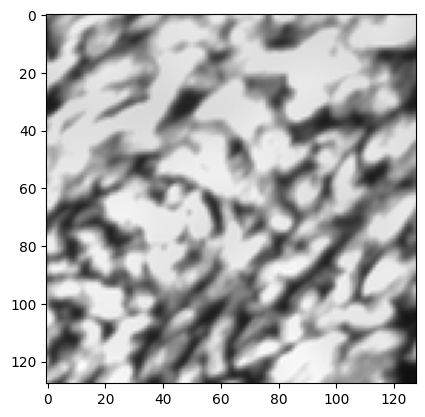

In [10]:
plt.imshow(images.cpu()[2][0,:,:], cmap='gray',vmin=0,vmax=1)

In [11]:
x_hat[0][0].cpu()[0,:,:].max()

tensor(0.6041)

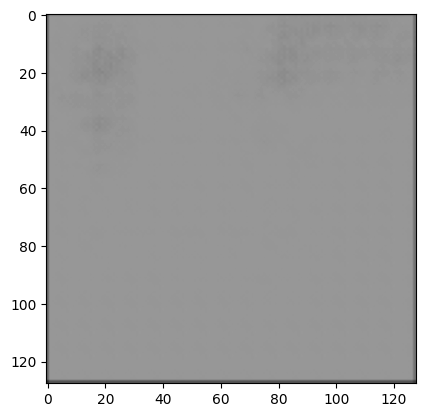

In [12]:
plt.imshow(x_hat[0][2].cpu()[0,:,:], cmap='gray',vmin=0,vmax=1)

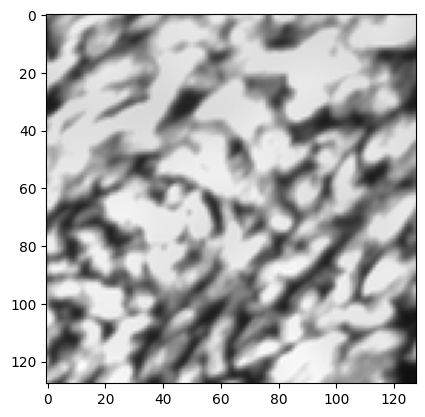

In [14]:
plt.imshow(x_hat[1][2].cpu()[0,:,:], cmap='gray',vmin=0,vmax=1)

In [580]:
x_hat[4][0]

tensor([-0.3087, -1.0942], device='cuda:0')

In [581]:
im_core_22_patch0 = im_core_22[:, 0:0 + 32, 0:0+32]

NameError: name 'im_core_22' is not defined

In [61]:
im_core_22_patch1000 = im_core_22[:, 1000:1000 + 32, 1000:1000+32]

In [74]:
im_core_22_patch0.max()

2419

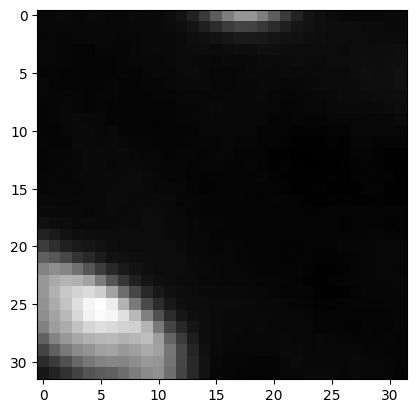

In [64]:

plt.imshow(im_core_22_patch1000[0,:,:], cmap='gray')

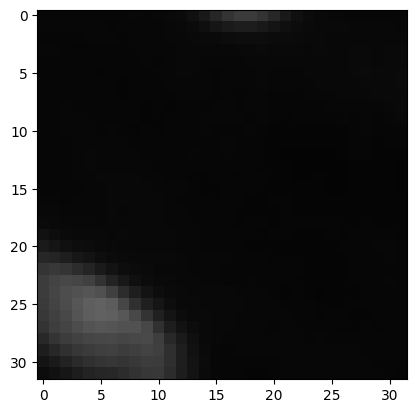

In [98]:
info = np.iinfo(im_core_22_patch0.dtype) # Get the information of the incoming image type
data = (im_core_22_patch1000/ info.max)
plt.imshow(data[0,:,:], cmap='gray',vmin=0,vmax=0.5)

In [89]:
im_core_22_patch1000.max()

34060

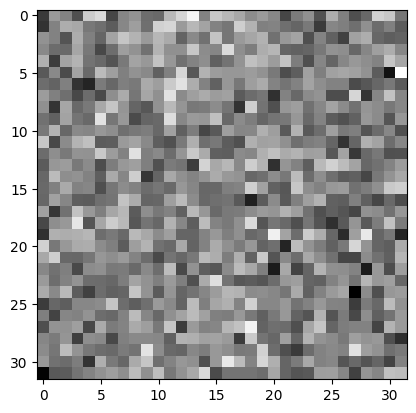

In [73]:
import tifffile

im_core_1_patch_0 = tifffile.imread(patches_files[0])
plt.imshow(im_core_1_patch_0[0,:,:]/65535, cmap='gray')

In [53]:
import numpy as np
im_core_1_patch_0[0,:,:].astype(np.uint8).max()

190

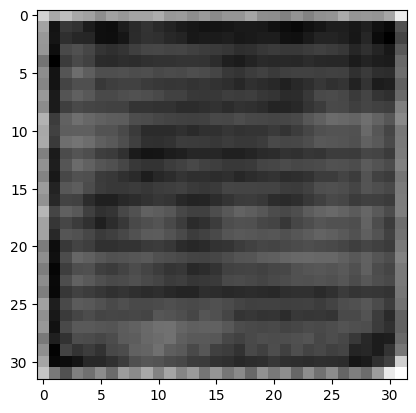

In [35]:
plt.imshow(x_hat[0].cpu()[0][0,:,:], cmap='gray')

In [31]:
loss

{'loss': tensor(0.0558, device='cuda:0'),
 'Reconstruction_Loss': tensor(0.0551, device='cuda:0'),
 'KLD': tensor(-3.0143, device='cuda:0')}